# End-to-End Time Series Analysis

Credits to : https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b for its excellent explanation as to how to perform Data Exploration, Wrangling and Forecasting on a time series data set. Through this notebook, insights on the tools used and analysis to be done are enhanced from techniques mentioned in the Medium article.

In [0]:
import warnings
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from fbprophet import Prophet
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid


warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [0]:
df = pd.read_excel("Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [6]:
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [7]:
print("Start Date: {}".format(furniture['Order Date'].min().date()))
print("End Date: {}".format(furniture['Order Date'].max().date()))

Start Date: 2014-01-06
End Date: 2017-12-30


## Data Preprocessing

We need to remove columns we do not need, check missing values and aggregate sales by date

In [0]:
def drop_cols(furniture_df):
    cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 
            'Customer ID', 'Customer Name', 'Segment', 'Country', 
            'City', 'State', 'Postal Code', 'Region', 'Product ID',
            'Category', 'Sub-Category', 'Product Name', 'Quantity',
            'Discount', 'Profit']

    furniture_df.drop(cols, axis=1, inplace=True)
    furniture_df = furniture_df.sort_values('Order Date')
    return furniture_df

In [0]:
furniture = drop_cols(furniture)

In [10]:
# Check for any null values
print("Check for Null values:")
furniture.isnull().sum()

Check for Null values:


Order Date    0
Sales         0
dtype: int64

In reality, predicting sales by month may be more helpful and less noisy than predicting daily sales. Predicting total sales of future months can help in planning for inventory

In [0]:
# Find Monthly Sales of furniture
furniture = furniture.set_index('Order Date')
furniture_monthly_sales = pd.DataFrame(furniture['Sales'].resample('M').sum())

In [12]:
furniture_monthly_sales.head()

,Sales
Order Date,
2014-01-31,6242.525
2014-02-28,1839.658
2014-03-31,14573.956
2014-04-30,7944.837
2014-05-31,6912.787


## Stationarity Tests

To test for stationarity, we can use the Augmented Dickey-Fuller Test (Also known as the unit root test). You can learn more about it at: https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test

In [13]:
# calculate stationarity test of time series data
X = furniture_monthly_sales['Sales'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.699026
p-value: 0.000085
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601


Our statistic value of -4.699026 is less than the value of -2.925 at 5%. This suggests that we can reject the null hypothesis with a significance level of less than 5% (i.e. a low probability that the result is a statistical fluke). Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

## Visualizing Furniture Sales Time Series Data

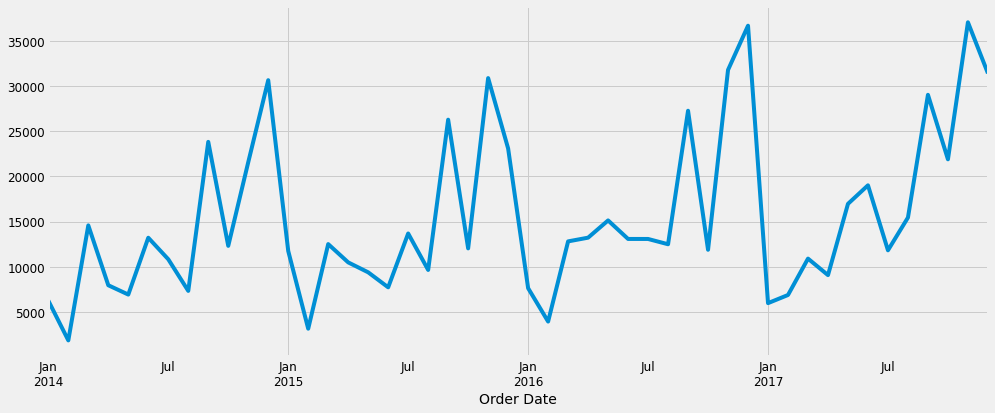

In [14]:
y = furniture_monthly_sales['Sales']
y.plot(figsize=(15, 6))
plt.show()

Sales of furniture exhibit strong seasonality across the years

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

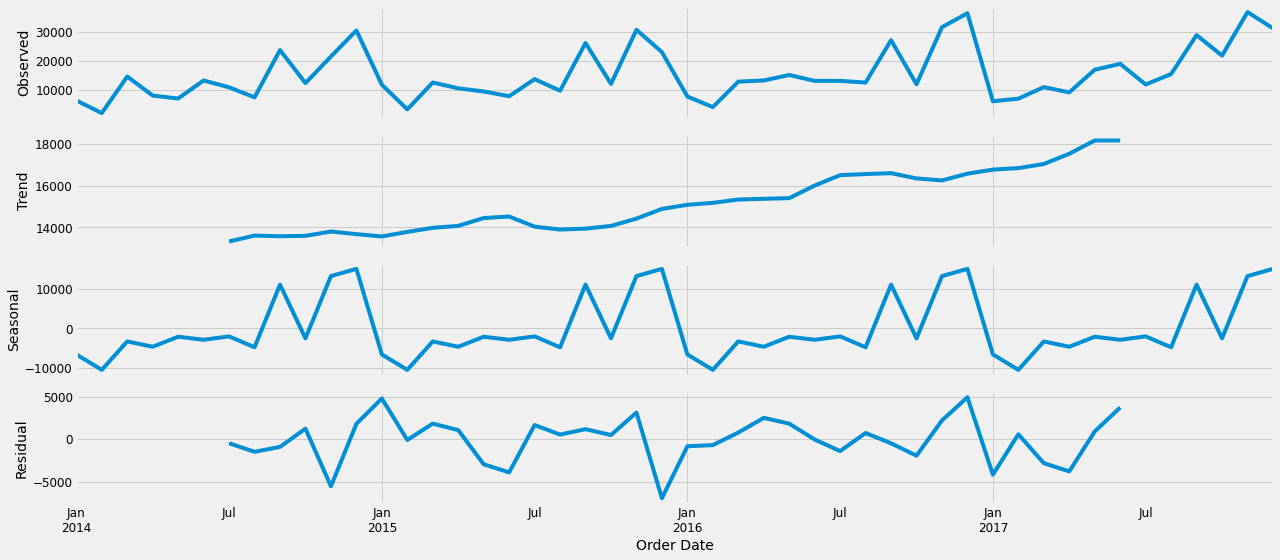

In [15]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(furniture_monthly_sales['Sales'], model='additive')
fig = decomposition.plot()
plt.show()

The trend and seasonal components are very apparent for furniture data! Although our stationarity test implies that monthly furniture sales is nonstationary, there is still a gentle trend component. This shows that we should always be cautious and break down our time series into components and visualize them before making judgements based on statistical tests

## Time Series Forecasting with ARIMA

Now that we have prepared the data, we can now do time-series forecasting with it. Specifically, I foresee the business scenario as predicting sales one quarter ahead. Hence, train-test split will be done accordingly, with the last quarter of the data used as test data

In [16]:
# Examples of parameters of SARIMA
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) 
                for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [17]:
# Train Test Split
furniture_train = furniture_monthly_sales[:-3]
print("Train Data: {}".format(furniture_train.tail()))
furniture_test = furniture_monthly_sales[-3:]
print("\n")
print("Test Data: {}".format(furniture_test.tail()))

Train Data:                  Sales
Order Date            
2017-05-31  16957.5582
2017-06-30  19008.5867
2017-07-31  11813.0220
2017-08-31  15441.8740
2017-09-30  29028.2060


Test Data:                  Sales
Order Date            
2017-10-31  21884.0682
2017-11-30  37056.7150
2017-12-31  31407.4668


In [18]:
## Perform Auto SARIMAX to find the best parameters for SARIMAX based on lowest AIC
params = []
seasonal_params = []
aics = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(furniture_train['Sales'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            params.append(param)
            seasonal_params.append(param_seasonal)
            aics.append(results.aic)
#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

idx = aics.index(min(aics))
print("Best parameters for SARIMA: ARIMA{}x{}12 - AIC:{}".format(params[idx], seasonal_params[idx], aics[idx]))


Best parameters for SARIMA: ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:377.66026619558824


The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 297.78. Therefore we should consider this to be optimal option

In [0]:
mod = sm.tsa.statespace.SARIMAX(furniture_train['Sales'],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1675      0.492     -0.340      0.734      -1.132       0.797
ma.L1         -0.8769      0.215     -4.086      0.000      -1.298      -0.456
ar.S.L12      -0.1613      0.304     -0.532      0.595      -0.756       0.434
sigma2      2.499e+07   2.94e-09   8.51e+15      0.000     2.5e+07     2.5e+07


In [0]:
one_step_ahead_mod = sm.tsa.statespace.SARIMAX(furniture_monthly_sales['Sales'],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
one_step_ahead_results = one_step_ahead_mod.fit()

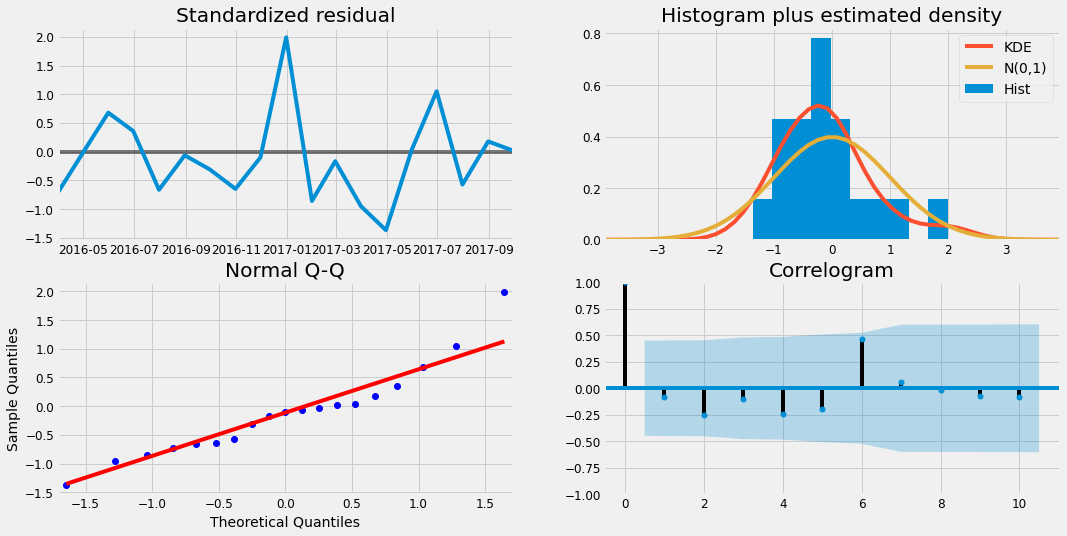

In [20]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed.

## Validating forecasts

We will use dynamic and 1-step ahead forecasts in statsmodels' SARIMAX model functionality.  
What are 1-step and dynamic forecasts? 
* 1 step ahead forecasts are forecasts that forecast 1 period ahead consistently. 
* Dynamic Forecasts rely on 1 step ahead forecasts up to a certain point, then it performs predictions using previous dates' predictions as input

1 Step-ahead forecasts:

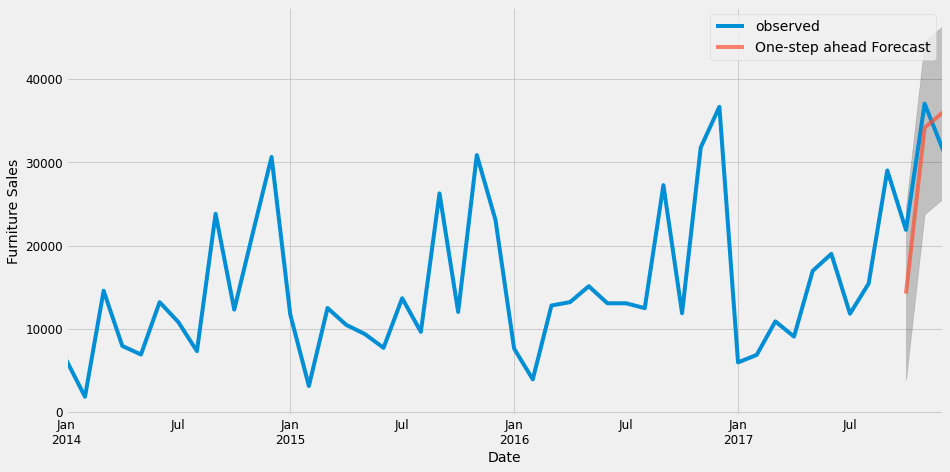

In [21]:
pred = one_step_ahead_results.get_prediction(start=pd.to_datetime('2017-10-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Dynamic Forecasts (forecast for last quarter of 2017 as test data):

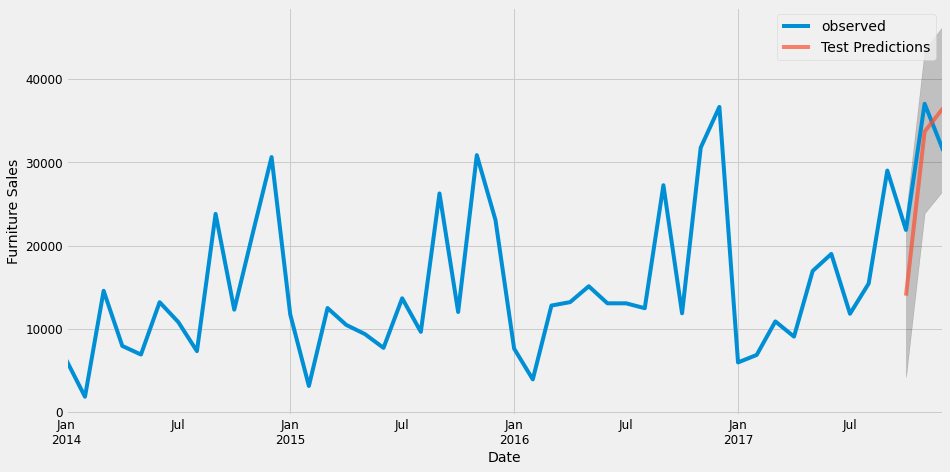

In [22]:
pred = results.get_prediction(start='2017-10-31', dynamic='2017-10-31', end='2017-12-31')
pred_ci = pred.conf_int()
pred_ci = pred_ci.loc['2017-10-31':]

ax = furniture_monthly_sales['Sales']['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Test Predictions', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

The forecasts seem to be close to our out-of-sample results. But this is just for the last quarter of 2017, what about the rest of the year? To ensure a more robust data validation, we have to use walk-forward validation

In [0]:
def walk_forward_validation_error(X, window, n_train, n_records):
    rms_errors = []
    for i in range(n_train, n_records-window+1):
        train, test = X[0:i], X[i:i+window]
        model = sm.tsa.statespace.SARIMAX(train,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 0, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        results = model.fit()
        forecasts = results.forecast(steps=window)
        # Compute the root-mean-square
        rms = np.sqrt(mean_squared_error(forecasts, test))
        rms_errors.append(rms)
    print("Average Root Mean Square Error (Using Walk-Forward Validation):")
    print(np.mean(rms_errors))

In [34]:
# Get average walk-forward validation error, using whole of 2017 as validation data (forecast window is quarter by quarter)
n_train = len(furniture_monthly_sales[:'2017-01-01']['Sales'])
n_records = len(furniture_monthly_sales['Sales'])
X = furniture_monthly_sales['Sales']
walk_forward_validation_error(X, 3, n_train, n_records)

Average Root Mean Square Error (Using Walk-Forward Validation):
4899.006436129634


In [35]:
# Get average walk-forward validation error, using whole of 2017 as validation data (forecast window is month by month)
walk_forward_validation_error(X, 1, n_train, n_records)

Average Root Mean Square Error (Using Walk-Forward Validation):
4648.622455574091


We will use this walk-forward validation error as a comparison with other models' results, i.e. Prophet etc.

## Visualizing Forecasts into the future

We can forecasts many steps ahead and plot its trend, to get a glimpse on what future sales may roughly look like. Notice that the confidence interval widens further into the future. This is due to increased uncertainty as we forecast more and more into the future

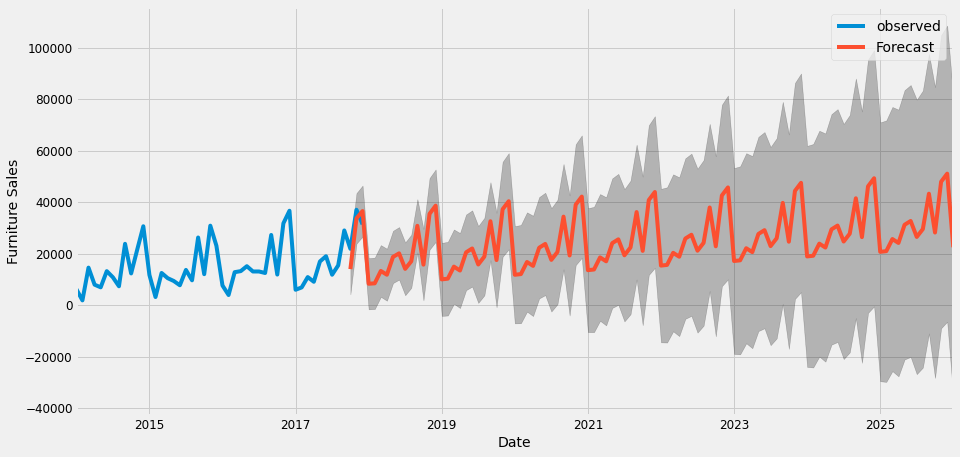

In [26]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()  
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

## Time Series Forecasting with Prophet
Let's fit a Prophet model and compare the results with our time series model. We will use validation to select the best hyperparameters


In [32]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 30


In [0]:
def prophet_walk_forward_validation_error(X, window, n_train, n_records, hyp_param):
    rms_errors = []
    for i in range(n_train, n_records-window+1):
        train, test = X[0:i], X[i:i+window]
        model = Prophet(changepoint_prior_scale = hyp_param['changepoint_prior_scale'],
                         n_changepoints = hyp_param['n_changepoints'],
                         seasonality_mode = hyp_param['seasonality_mode'],
                         yearly_seasonality = True,
                         interval_width=0.95)
        model.fit(train)
        forecasts = model.make_future_dataframe(periods=window, freq='M')
        preds = model.predict(forecasts)[['ds','yhat']]
        # Compute the root-mean-square
        rms = np.sqrt(mean_squared_error(preds['yhat'][-3:], test['y']))
        rms_errors.append(rms)
    return np.mean(rms_errors)

In [56]:
n_train = len(furniture_monthly_sales[:'2017-01-01']['Sales'])
n_records = len(furniture_monthly_sales['Sales'])
prophet_df  = furniture_monthly_sales.copy().reset_index()
prophet_df.rename(columns={'Order Date': 'ds', 'Sales': 'y'}, inplace=True)
hyp_param_record = {'min_rms': np.inf, 'best_hyp_param': {}}
for hyp_param in grid:
  rms_error = prophet_walk_forward_validation_error(prophet_df, 3, n_train, n_records, hyp_param)
  if rms_error < hyp_param_record['min_rms']:
    hyp_param_record['min_rms'] = rms_error
    hyp_param_record['best_hyp_param'] = hyp_param

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 27.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 28.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 29.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run

In [57]:
print("Lowest Walk-forward validation error: {}".format(hyp_param_record['min_rms']))
print("Best hyperparameter: {}".format(hyp_param_record['best_hyp_param']))

Lowest Walk-forward validation error: 4228.885157642411
Best hyperparameter: {'changepoint_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


Prophet performs better  than ARIMA as seen from the lower walk-forward validation error


The interesting part about Prophet, is that it has in-built methods to plot out time series components without us having to call out external libraries

In [61]:
model = Prophet(changepoint_prior_scale = hyp_param_record['best_hyp_param']['changepoint_prior_scale'],
                n_changepoints = hyp_param_record['best_hyp_param']['n_changepoints'],
                seasonality_mode = hyp_param_record['best_hyp_param']['seasonality_mode'],
                yearly_seasonality = True,
                interval_width=0.95)
model.fit(prophet_df[prophet_df['ds'] < '2017-01-01'])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 27.


In [0]:
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

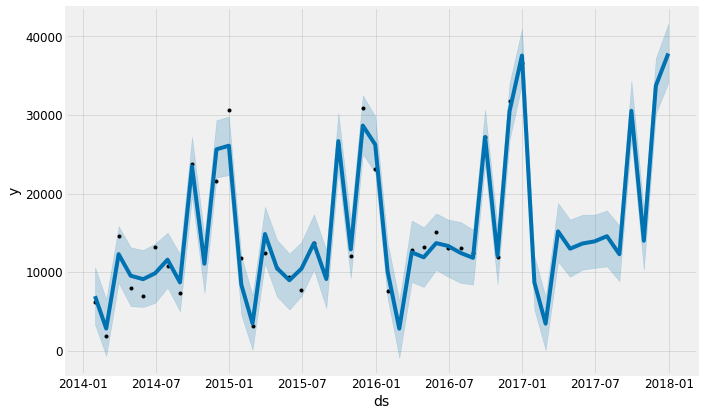

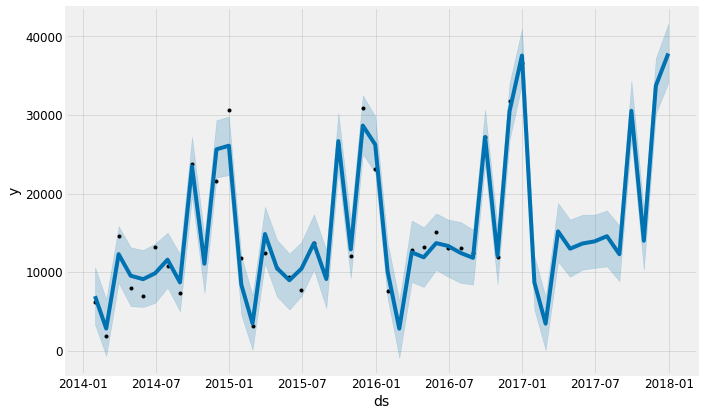

In [67]:
model.plot(forecast)

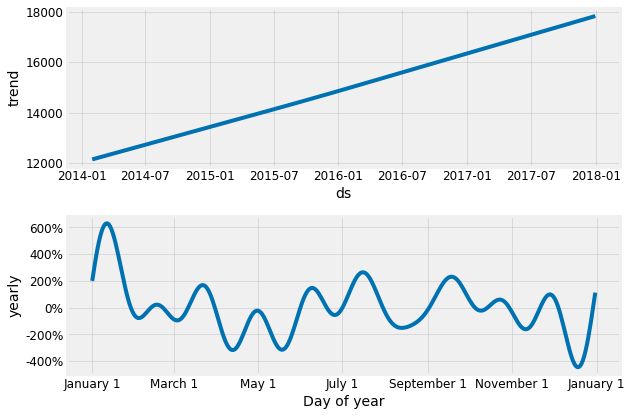

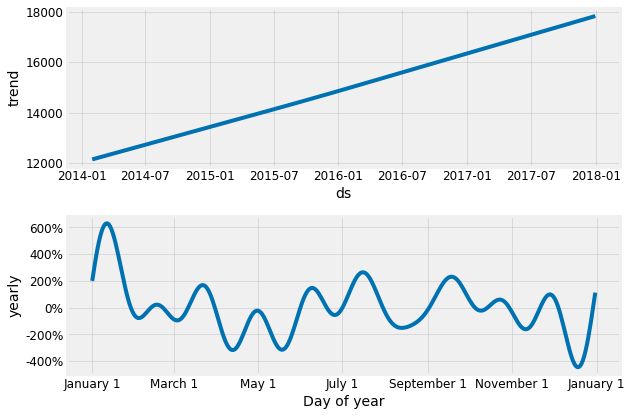

In [68]:
model.plot_components(forecast)

We can see from the graph above that sales for furniture tend to be high at the beginning of the year, then tapers off towards the end of the year

That is all for this notebook.

Points of improvement:

* We can try using multivariate time series methods, to boost accuracy

* We can explore using Neural Networks for forecasting, to compare its results against Prophet and ARIMA. One architecture we can utilize is the LSTM architecture

* More analysis can be done for other categories of products as well besides furniture to see if they correlate with each other